# Bayesian regression example

This script is created to show a workflow of bayesian regression to fit a model to data. 

Author: Qingkai Kong

Email: qingkai.kong@gmail.com

Modification History:

2015-10-14, create the script

In [1]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

Populating the interactive namespace from numpy and matplotlib


## Create data and adding noise
We generate data based on the equation 2*arctan(x/3), and add a gaussian noise to it. Assume this is our observed data with some noise in it, and we don't know how the data was generated, and want to use equation A*arctan(x/B) to model it, and find parameter A and B based on the data we obeserved. 

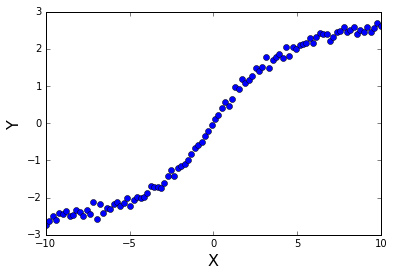

In [2]:
#create some data and adding a white noise to the data
x = np.linspace(-10, 10, 100)
A = 2
B = 3
#We use the following equation to generate our data
y = A*np.arctan(x/B)

#adding the noise 
noise = np.random.normal(0,0.1,len(y))
y_observe = y + noise

plt.plot(x, y_observe, 'o')
plt.xlabel('X', fontsize = 16)
plt.ylabel('Y', fontsize = 16)
plt.show()

## Grid search least square regression
Before we go further to use Bayesian approach, let's use a very common numerical way to solve this problem first - least square regression. To make the problem simple, I just use a grid search method to minimize the sum of squared residual between observed data and predicted data. Let's assume our parameter space for A and B range from 1 to 10, we calcuate the predicted value by using each parameter pair A and B, and calculate the sum of the residual to the observed data. We then can find the minimum of the sum of the residual square, and get the corresponding A and B as the parameters as the model that best fit the data. 

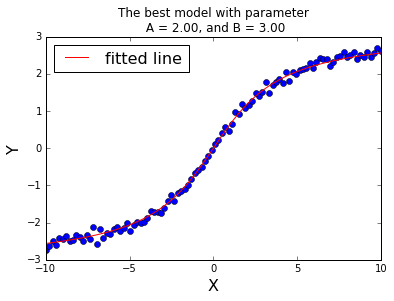

In [3]:
A_space = np.arange(1, 10.25, 0.25)
B_space = np.arange(1, 10.25, 0.25)
residual_mat = np.zeros((len(A_space), len(B_space)))
#loop through parameter space, assume we know that A and B are ranging from 1 - 9
for i, A in enumerate(A_space):
    for j, B in enumerate(B_space):
        #estimate y
        y_est = A*np.arctan(x/B)
        sum_residual = sum((y_est - y_observe)**2)
        residual_mat[i, j] = sum_residual
        
#get the index of the smallest residual of all the models
ix_min = np.where(residual_mat == np.min(residual_mat))
A_est, B_est= A_space[ix_min[0][0]], B_space[ix_min[1][0]]
#plot the fitting line on the observed data
plt.plot(x, y_observe, 'o')
plt.plot(x, A_est*np.arctan(x/B_est), 'r', label = 'fitted line')
plt.xlabel('X', fontsize = 16)
plt.ylabel('Y', fontsize = 16)
plt.legend(fontsize = 16, loc = 2)
plt.title('The best model with parameter\n A = %.2f, and B = %.2f' %(A_est, B_est))
plt.show()

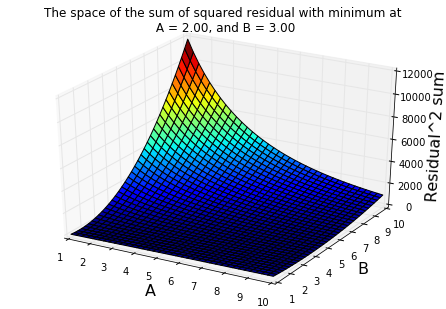

In [4]:
#visualize the space of the sum of squared residual
fig = plt.figure()
ax = Axes3D(fig)
X, Y = np.meshgrid(A_space, B_space)
ax.plot_surface(X, Y, residual_mat, rstride=1, cstride=1, cmap=cm.jet)
ax.set_xlabel('A', fontsize = 16)
ax.set_ylabel('B', fontsize = 16)
ax.set_zlabel('Residual^2 sum', fontsize = 16)
plt.title('The space of the sum of squared residual with minimum at\n A = %.2f, and B = %.2f' %(A_est, B_est))
plt.show()

## Bayesian approach using MCMC
Even though we don't know what is A and B before hand, but my friend told me A should be around 2, and B should be around 3. How could we bring in this additional informaiton into our modeling? We can use Bayesian approach, and solve the problem from statistical point of view. We can think $Y = f(X) + noise$, where f(X) is the true model we want to fit, and noise is comming from the measurements, $X=[x_1, x_2, ..., x_N]$, and $Y=[y_1, y_2, ..., y_N]$. For simplicity we treat noise as white noise, that is, noise fllow normal distribution noise~$N(0, \sigma^2$), assume we know the variance. Therefore, the predicting outcomes Y should be normally disbtributed with an expected value $f(X_i)$, that is, $Y_i$~$N(f(X_i)$, $\sigma^2$). This is to say, for each data point in observed data, it is normally distributed and centered at $f(X_i)$. If we assume each of the observed data point is independent, we can then get the likelihood function as the multiply of each $Y_i$~$N(f(X_i)$, $\sigma^2$), so $Y$~$N(f(X)$, $\sigma^2$) (a gaussian multiply another gaussian is still a gaussian). If we stop here, and estimate the parameter A and B by maximize this likelyhood function, then this is MLE (Maximum Likelihood Estimation). 

Now as we are very certain that A is around 2, B is around 3, so we can use a normal distribution to show our certainty. $A$~$N(2, 0.01)$ and $B$~$N(3, 0.01)$, that is we use a narrow gaussian (variance 0.01) to show we are quite certain that the parameter is centered around this mean value. 

Then we can use Bayesian equation $P(A, B|Y)=\frac{P(Y|A, B)P(A, B)}{P(Y)}$, where $P(Y)=\int\int P(Y|A, B)P(A, B)dAdB$, and $P(A, B) = P(A)P(B)$, since we can see the numerator is very easy to get, likelyhood function multiply prior, for current example, since they are all gaussian, so the numerator is also gaussian. But the denominator is a very ugly integral, not that easy to get. Since this denominator is used as a normalization factor to keep the posterior probability within [0, 1], it doesn't affect anything if we just want to know which A and B that maximize the posterior probability, this will be a MAP (Maximize A Posterior estimation). It is quite similar to MLE, differs just in which probability we try to maximize. 

But if we want to get the posterior probability, we must figure out a way to solve the denominator! Here, MCMC (Markov Chain Monte Carlo) comes to save. It is a very elegant simulation procedure that is designed to get the posterior probability without solving the denominator. In this link, you can get a really nice intuition of the basic idea. Anyway, the following I will use MCMC to get an estimation of the posterior probability of both A and B (I assume we know the variance in the likelihood function, if we don't know the variance, we can add this paramter in, and estimate it as well).

In [7]:
from pymc import Model, Normal, HalfNormal
import pymc as pm
import corner

In [8]:
def myModel(x, y_observe): 
    # Priors for unknown model parameters
    #Note tau is the 1/sigma^2, e.g 1/σ^2
    A_prior = pm.distributions.Normal('A', mu = 2, tau = 100)
    B_prior = pm.distributions.Normal('B', mu = 3, tau = 100)
    
    #You can try different distributions on the variance of the noise
    #sigma = basic_model.HalfNormal('sigma', 1)
    #tau_prior = pm.distributions.Gamma("tau", alpha=0.001, beta=0.001)
    #Here I use sigma = 0.1
    tau_prior = 1.0/0.1**2
    
    # Expected value of outcome
    @pm.deterministic(plot=False)
    def f(x = x, A=A_prior, B=B_prior):
        return A*np.arctan(x/B)
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.distributions.Normal('Y_obs', mu = f, tau = tau_prior, value = y_observe, observed=True)
    return locals()

2.0217220796071174 3.0178646063141175
 [-----------------100%-----------------] 50000 of 50000 complete in 3.9 secPlotting B
Plotting A


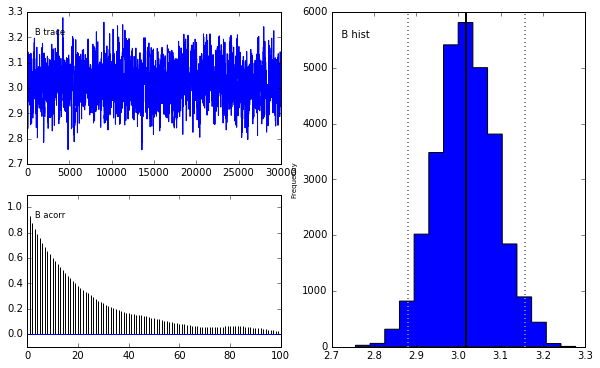

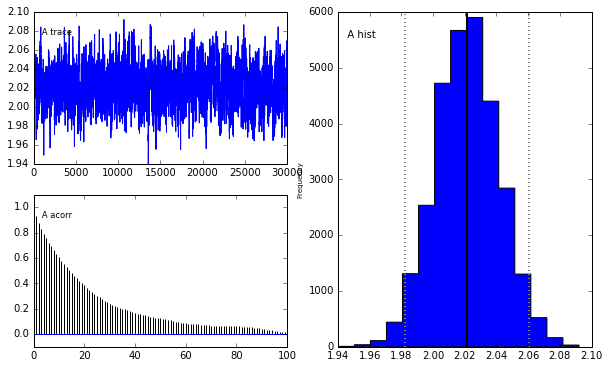

In [9]:
#Here I also calculate MAP to get the best solution
model = pm.Model(myModel(x, y_observe))
map_ = pm.MAP(model)
map_.fit()
#print the MAP solution
print(map_.A_prior.value, map_.B_prior.value)

#Use MCMC to get the distribution of parameters
mcmc = pm.MCMC(myModel(x, y_observe))
mcmc.sample(iter=50000, burn=20000)
pm.Matplot.plot(mcmc)
#The trace is the series of the randm walk for each parameter, what we expect from this figure is no obvious trend. If the beginning of the run looks very different from the end, then the simulated Markov Chain is nowhere near stationarity and we need run longer.
#The Autocorrelation plot shows the cross-correlation of a signal with itself at different points in time. The x axis is time lag, and y is autocorrelation coefficient. What we are looking for is what lag the autocorrelations decrease to being not significantly different from zero. If autocorrelation is high, you will have to use a longer burn-in, and you will have to draw more samples after the burn-in to get a good estimate of the posterior distribution..Low autocorrelation means good exploration. Exploration and convergence are essentially the same thing. If a sampler explores well, then it will converge fast, and vice versa. Part of the confusion here is that the book does not explain the concept of convergence very well.
#Reference: http://stats.stackexchange.com/questions/116861/posterior-autocorrelation-in-pymc-how-to-interpret-it

In [10]:
print(mcmc.A_prior.summary())
print(mcmc.B_prior.summary())


A:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	2.021            0.02             0.001            [ 1.982  2.061]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	1.983            2.008           2.022          2.035         2.061
	
None

B:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	3.017            0.07             0.002            [ 2.881  3.159]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	2.879            2.971           3.017          3.066         3.158
	
None


/Users/qingkaikong/anaconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


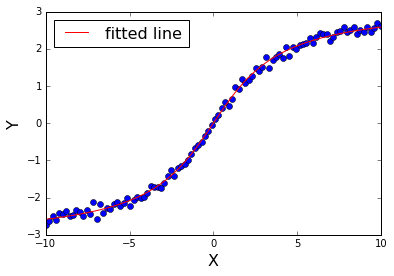

In [11]:
#plot the fitting
plt.plot(x, y_observe, 'o')
plt.plot(x, np.mean(mcmc.A_prior.trace())*np.arctan(x/np.mean(mcmc.B_prior.trace())), 'r', label = 'fitted line')
plt.xlabel('X', fontsize = 16)
plt.ylabel('Y', fontsize = 16)
plt.legend(fontsize = 16, loc = 2)
plt.show()

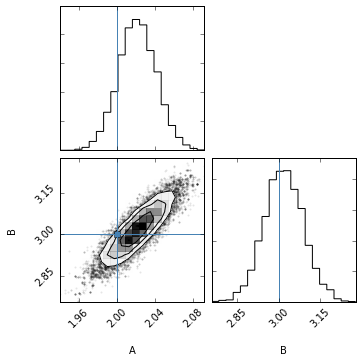

In [12]:
#let's plot the best solution with the true solution, you need corner as dependencies, e.g. sudo pip install corner
samples = array([mcmc.A_prior.trace(),mcmc.B_prior.trace()]).T
tmp = corner.corner(samples[:,:], labels=['A','B'], 
                truths=[2, 3])